## Hyperparameter optimization using pyGPGO
#### by José Jiménez (Oct 18, 2017)

In this tutorial, we will learn the basics of the Bayesian optimization (BO) framework through a step-by-step example in the context of optimizing the hyperparameters of a binary classifier. But first of all, where is Bayesian optimization useful?

There are a lot of case scenarios, one would typically use the BO framework in situations like:

* The objective function has no closed-form
* No gradient information is available
* In presence of noise

The BO framework uses a surrogate model to approximate the objective function and chooses to optimize it instead according to a chosen criteria. For an in-depth introduction to the topic, we whole-heartedly recommend reading [@Snoek2012, @Jimenez2017].


Let's start by creating some synthetic data that we will use later for classification.

In [1]:
import numpy as np
from sklearn.datasets import make_moons

np.random.seed(20)
X, y = make_moons(n_samples = 200, noise = 0.3) # Data and target

Before going any further, let's visualize it!

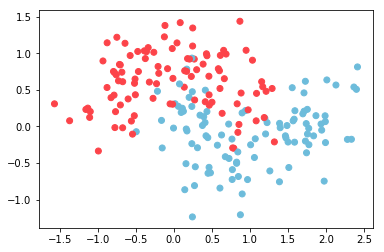

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cm_bright = ListedColormap(['#fc4349', '#6dbcdb'])
    
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c = y, cmap = cm_bright)
plt.show()

Let's say that we want to use a Support Vector Machine (SVM) with the radial basis function kernel classifier on this data, which has two usual parameters to optimize, $C$ and $\gamma$. We need to first define a target function that takes these two hyperparameters as input and spits out an error (e.g, using some form of cross validation). Define also a dictionary, specifying parameters and input spaces for each.

In [3]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

def evaluateModel(C, gamma):
    clf = SVC(C=10**C, gamma=10**gamma)
    return np.average(cross_val_score(clf, X, y))

params = {'C':      ('cont', (-4, 5)),
          'gamma':  ('cont', (-4, 5))
         }

Now comes the fun part, where we specify our BO framework using `pyGPGO`. We are going to use a Gaussian Process (GP) model to approximate our true objective function, and a _covariance function_ that measures similarity among training examples. An excellent introduction to Gaussian Process regression can be found in [@Rassmussen-Williams2004]. We are going to use the squared exponential kernel for this example, that takes the form:

$$k(r) = \exp\left(-\dfrac{r^2}{2l^2} \right)$$,

where $r = |x - x'|$ two examples.

In [4]:
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.covfunc import squaredExponential
sexp = squaredExponential()
gp = GaussianProcess(sexp)

We specify now an _acquisition function_, that will determine the behaviour of the BO procedure when selecting a new point. For instance, it is very common to use the Expected Improvement (EI) acquisition, that will both take into account the probability of improvement of a point and its magnitude:

In [5]:
from pyGPGO.acquisition import Acquisition
acq = Acquisition(mode = 'ExpectedImprovement')

We're almost done! Finally call the `GPGO` class and put everything together. We'll run the procedure for 20 epochs.

In [6]:
from pyGPGO.GPGO import GPGO
gpgo = GPGO(gp, acq, evaluateModel, params)
gpgo.run(max_iter = 20)

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 3.46651841 -2.6880531 ]. 	  0.8392751039809864 	 0.8392751039809864
init   	 [ 2.49038664  3.45075421]. 	  0.5199049316696375 	 0.8392751039809864
init   	 [ 4.95443081  1.97658435]. 	  0.7841651812240048 	 0.8392751039809864
1      	 [ 3.94059684  2.58310218]. 	  0.62403446227 	 0.839275103981
2      	 [ 3.7573473  -1.74422885]. 	  0.844325609031 	 0.844325609031
3      	 [ 2.80940609 -1.9626974 ]. 	  0.849376114082 	 0.849376114082
4      	 [ 4.1755997  1.2277553]. 	  0.784016636958 	 0.849376114082
5      	 [ 5.         0.6840808]. 	  0.829322638146 	 0.849376114082
6      	 [ 4.05318879 -0.2290376 ]. 	  0.884432560903 	 0.884432560903
7      	 [ 3.02043356 -0.65888086]. 	  0.879382055853 	 0.884432560903
8      	 [ 3.03205495  0.43289084]. 	  0.80421865716 	 0.884432560903
9      	 [ 2.48114919  1.9671316 ]. 	  0.784165181224 	 0.884432560903
10     	 [ 1.67398519  0.89102948]. 	  0.819073083779 	 0.884432560903
1

Finally retrieve your result!

In [7]:
gpgo.getResult()

(OrderedDict([('C', 0.64242052821266804), ('gamma', 0.019309672599732992)]),
 0.88933452168746285)

### References

[@Rasmussen-Williams2004]: Rasmussen, C. E., & Williams, C. K. I. (2004). Gaussian processes for machine learning. International journal of neural systems (Vol. 14). http://doi.org/10.1142/S0129065704001899

[@Snoek2012]: Snoek, J., Larochelle, H., & Adams, R. P. (2012). Practical Bayesian Optimization of Machine Learning Algorithms. Adv. Neural Inf. Process. Syst. 25, 1–9. http://doi.org/2012arXiv1206.2944S

[@Jiménez2017]: Jiménez J., Ginebra, J. (2017). Bayesian optimization in machine-learning. http://hdl.handle.net/2117/105999


